<a href="https://colab.research.google.com/github/masta-g3/robinmodel/blob/main/robinmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *#FinRes:* Do Techincal Indicators Work?

The *#FinRes* series are a collection of bite-sized pieces on financial research and trading models. In each of these pieces I investigate a specific question or test a particular hypothesis to uncover *the ways of the market*.

On this first installment I analyze **if technical indicators work**, meaning, do they have any predictive power over short-term (i.e. 1 day) stock returns? Intuition tells us the answer is **no**, but better get some evidence before commiting to it.

To analyze this question, I use the TA library and generate 77 technical analysis indicators for a selected stock. Then I use these signals (and some extra derived ones) as input to a Random Forest and a XGBoost model, so we can evaluate their predictive power.

In [1]:
!pip install yfinance >> /dev/null
!pip install mplcyberpunk >> /dev/null
!pip install ta >> /dev/null
!pip install pykalman >> /dev/null
print('Done with installs.')

Done with installs.


In [92]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import mplcyberpunk

from ta import add_all_ta_features
from pykalman import KalmanFilter
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
plt.style.use("cyberpunk")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Load a Ticker & Get Features
The selected stock for the analysis is **AMD**, although I tried several other tickers and achieved similar insights.

*Note:* financial price time series are known for having a significant day-to-day noise component, which might confuse the model. I try to reduce this noise by using a Kahlman filter smoothing on the price series.


In [101]:
## Ticker data.
ticker = 'AMD'
stock = yf.Ticker(ticker)
stock_df = stock.history(start='2020-01-01', end='2021-01-01')

smoother = KalmanFilter(transition_matrices = [1],
              observation_matrices = [1],
              initial_state_mean = stock_df.iloc[0]['Close'],
              initial_state_covariance = 1,
              observation_covariance=1,
              transition_covariance=0.5)

stock_df['Open_Smooth']  = smoother.filter(stock_df['Open'])[0]
stock_df['High_Smooth']  = smoother.filter(stock_df['High'])[0]
stock_df['Low_Smooth']  = smoother.filter(stock_df['Low'])[0]
stock_df['Close_Smooth']  = smoother.filter(stock_df['Close'])[0]

## Add all TA features.
stock_df = add_all_ta_features(
    stock_df, open="Open_Smooth",
    high="High_Smooth", low="Low_Smooth",
    close="Close_Smooth", volume="Volume")

stock_df.drop(columns=['trend_psar_up', 'trend_psar_down', 'trend_stc',
                       'trend_mass_index', 'momentum_tsi', 'trend_trix'], inplace=True)

## Additionally we add rate of change and weekly std for each feature.
idx_last_ta = stock_df.shape[1]
feats = stock_df.columns[11:idx_last_ta].tolist()

## 1D, 2D and 5D difference.
diffs1_df = stock_df[feats].diff()
diffs1_df.columns = map(lambda l: l+'_diff1', diffs1_df.columns)
diffs2_df = stock_df[feats].diff(2)
diffs2_df.columns = map(lambda l: l+'_diff2', diffs2_df.columns)
diffs5_df = stock_df[feats].diff(5)
diffs5_df.columns = map(lambda l: l+'_diff5', diffs5_df.columns)
## 5D StdDev.
stddev_df = stock_df[feats].rolling(5).std()
stddev_df.columns = map(lambda l: l+'_std5', stddev_df.columns)

## Combine.
feats_df = pd.concat([stock_df, diffs1_df, diffs2_df,
                      diffs5_df, stddev_df], axis=1)

idx_last_ta = feats_df.shape[1]
feats = feats_df.columns[11:idx_last_ta].tolist()
print(f'{len(feats)} total features.')

385 total features.


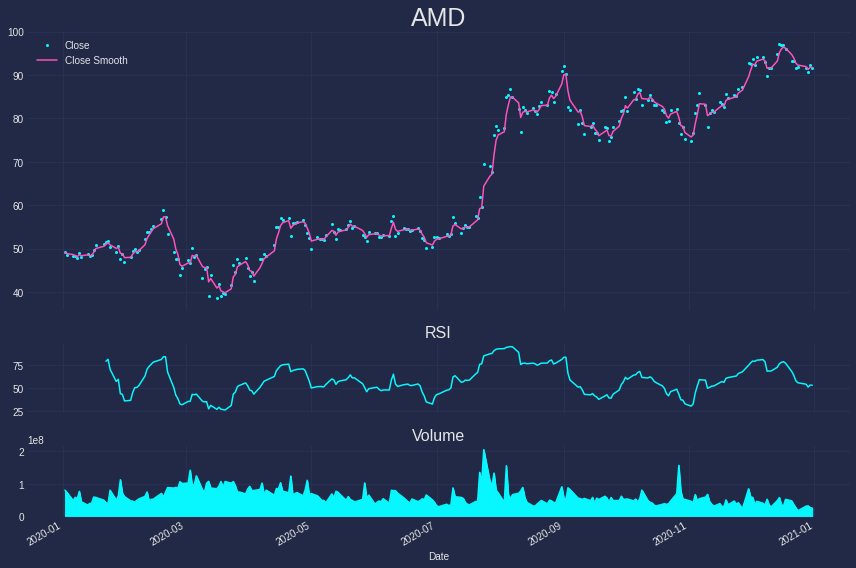

In [102]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=3, sharex=True,
                        gridspec_kw={'height_ratios':[4,1,1]})

## Prices and smoothed prices.
ax = axs[0]
feats_df['Close'].plot(ax=ax, ls='', marker='o', markersize=2, label='Close')
feats_df['Close_Smooth'].plot(ax=ax, ls='-', markersize=2, label='Close Smooth')
ax.legend()
ax.set_title(ticker, size=25)

## Some indicator.
ax = axs[1]
feats_df['momentum_rsi'].plot(ax=ax)
ax.set_title('RSI', size=16)

## Volume.
ax = axs[2]
feats_df['Volume'].plot.area(ax=ax)
ax.set_title('Volume', size=16)

fig.tight_layout();

## Train Random Forest
First model is a Random Forest Classifier, a classic yet powerful algorithm. 

The positive class will consist of instances where the next-day return is greater than 1%.

In [103]:
## Calculate returns of smoothed prices.
feats_df['ret'] = feats_df['Close'].pct_change()
feats_df['ret_smooth'] = feats_df['Close_Smooth'].pct_change()

## Next day returns.
feats_df['ret_next'] = feats_df['ret'].shift(-1)
feats_df['ret_type'] = 0
feats_df.loc[feats_df['ret_next'] > 0.01, 'ret_type'] = 1

## Next day returns (smooth).
feats_df['ret_next_smooth'] = feats_df['ret_smooth'].shift(-1)
feats_df['ret_type_smooth'] = 0
feats_df.loc[feats_df['ret_next_smooth'] > 0.01, 'ret_type_smooth'] = 1

In [104]:
## Create model input data.
model_df = feats_df[feats + ['Close', 'Close_Smooth', 'ret',
                             'ret_smooth','ret_type_smooth']].dropna()

## Divide dataset.
train_range = np.arange(0, np.ceil(model_df.shape[0] * 0.8))
test_range = np.arange(train_range[-1]+1, model_df.shape[0])

train_df = model_df.iloc[train_range]
test_df = model_df.iloc[test_range]

In [105]:
## Train model and evaluate.
clf = RandomForestClassifier(n_estimators=500, random_state=42,
                             n_jobs=-1, class_weight='balanced')

clf.fit(train_df[feats], train_df['ret_type_smooth'])

train_pred = clf.predict(train_df[feats])
test_pred = (clf.predict_proba(test_df[feats])[:, 1] > 0.4).astype(float)

print('Training results:\n',
      confusion_matrix(train_df['ret_type_smooth'], train_pred))

print('Test accuracy:\n',
      confusion_matrix(test_df['ret_type_smooth'], test_pred))

Training results:
 [[109   0]
 [  0  49]]
Test accuracy:
 [[29  1]
 [ 6  3]]


TRAINING:
Max return: 1.904
Actual return: 1.904

TEST:
Max return: 0.252
Actual return: 0.054


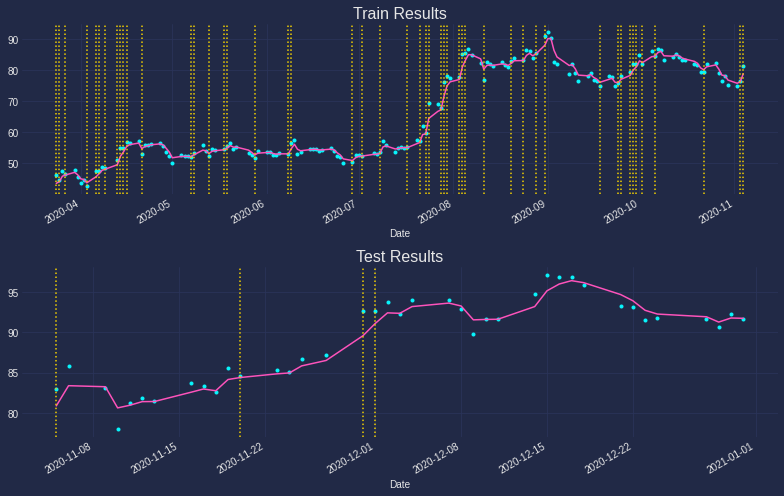

In [106]:
## Evaluate and plot returns.
fig, axs = plt.subplots(figsize=(11, 7), nrows=2, sharey=False)

ax = axs[0]
train_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
train_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 train_df.loc[train_pred.astype(bool)].index]
ax.set_title('Train Results', size=16)

print('TRAINING:')
print('Max return:', (train_df['ret'].shift(-1) * train_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (train_df['ret'].shift(-1) * train_pred).sum().round(3))

## Test.
ax = axs[1]
test_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
test_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 test_df.loc[test_pred.astype(bool)].index]
ax.set_title('Test Results', size=16)
fig.tight_layout()

print('\nTEST:')
print('Max return:', (test_df['ret'].shift(-1) * test_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (test_df['ret'].shift(-1) * test_pred).sum().round(3))

## Train XGBoost Model
The results with the Random Forest are... disappointing. Let's see if XGBoost can do better.

In [107]:
## Train model and evaluate.
clf = XGBClassifier()

clf.fit(train_df[feats], train_df['ret_type_smooth'])

train_pred = clf.predict(train_df[feats])
test_pred = (clf.predict_proba(test_df[feats])[:, 1] > 0.5).astype(float)

print('Training results:\n',
      confusion_matrix(train_df['ret_type_smooth'], train_pred))

print('Test accuracy:\n',
      confusion_matrix(test_df['ret_type_smooth'], test_pred))

Training results:
 [[109   0]
 [  0  49]]
Test accuracy:
 [[25  5]
 [ 8  1]]


TRAINING:
Max return: 1.904
Actual return: 1.904

TEST:
Max return: 0.252
Actual return: -0.034


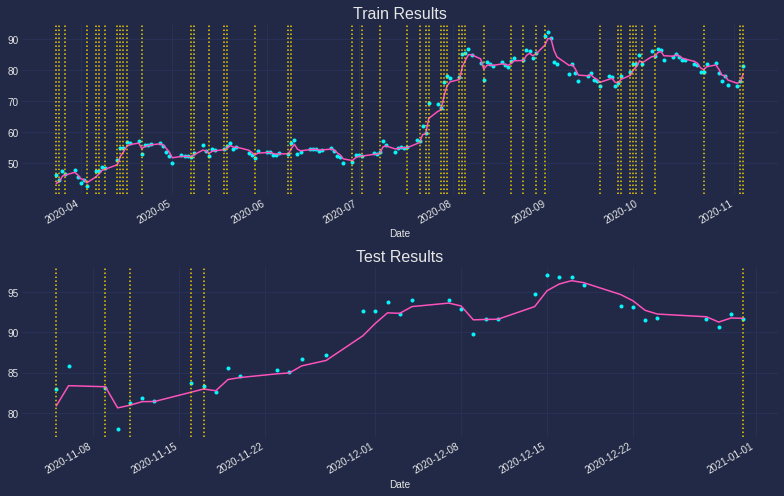

In [108]:
## Evaluate and plot returns.
fig, axs = plt.subplots(figsize=(11, 7), nrows=2, sharey=False)

ax = axs[0]
train_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
train_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 train_df.loc[train_pred.astype(bool)].index]
ax.set_title('Train Results', size=16)

print('TRAINING:')
print('Max return:', (train_df['ret'].shift(-1) * train_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (train_df['ret'].shift(-1) * train_pred).sum().round(3))

## Test.
ax = axs[1]
test_df['Close'].plot(ax=ax, ls='', marker='o', markersize=3)
test_df['Close_Smooth'].plot(ax=ax)
[ax.axvline(v, c=colors[2], ls=':') for v in
 test_df.loc[test_pred.astype(bool)].index]
ax.set_title('Test Results', size=16)
fig.tight_layout()

print('\nTEST:')
print('Max return:', (test_df['ret'].shift(-1) * test_df['ret_type_smooth']).sum().round(3))
print('Actual return:', (test_df['ret'].shift(-1) * test_pred).sum().round(3))

## Result Discussion
Both models produced poor results, even after using the smoothed prices series as input and augmented the dataset with a total of 385 features.

As mentioned in the introduction, this is in line with my expectations, as simply throwing a bunch of tranformed price variables into a regression and making lots of money seems unrealistic.